In [1]:
from spacerocks import SpaceRock
from spacerocks.time import Time
from spacerocks.observing import Observatory
from spacerocks.spice import SpiceKernel
from spacerocks.nbody import Simulation, Force

from astroquery.jplhorizons import Horizons

from astropy.time import Time as AstropyTime
from astropy import units as u
from astropy.coordinates import SkyCoord

import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

kernel = SpiceKernel()
kernel.load("/Users/kjnapier/data/spice/latest_leapseconds.tls")
# kernel.load("/Users/kjnapier/data/spice/de440s.bsp")
kernel.load("/Users/kjnapier/data/spice/sb441-n16.bsp")
#kernel.load("/Users/kjnapier/data/spice/sb441-n373s.bsp")
kernel.load("/Users/kjnapier/data/spice/de441_part-1.bsp")
kernel.load("/Users/kjnapier/data/spice/de441_part-2.bsp")
kernel.load("/Users/kjnapier/data/spice/earth_1962_240827_2124_combined.bpc")

In [2]:
kernel

SpiceKernel
 - /Users/kjnapier/data/spice/latest_leapseconds.tls
 - /Users/kjnapier/data/spice/sb441-n16.bsp
 - /Users/kjnapier/data/spice/de441_part-1.bsp
 - /Users/kjnapier/data/spice/de441_part-2.bsp
 - /Users/kjnapier/data/spice/earth_1962_240827_2124_combined.bpc

In [3]:
obscode = 'F51'
name = 'hsingwenlin'
w84 = Observatory.from_obscode(obscode)

In [4]:
epoch = Time.now()
t0 = epoch.epoch
epochs = np.arange(epoch.epoch - 1.0 * 365.25, epoch.epoch + 1.0 * 365.25, 1)
testdates = AstropyTime(epochs, format='jd', scale='utc')

In [5]:
epoch.tt().jd()

2460691.462860926

In [6]:
rock = SpaceRock.from_horizons(name=name, epoch=epoch, reference_plane='J2000', origin='ssb')
o = w84.at(rock.epoch, reference_plane="J2000", origin="ssb")

In [7]:
# light time could be slightly different

In [8]:
obs = rock.observe(o)

In [9]:
sim = Simulation.horizons(rock.epoch, reference_plane="J2000", origin="ssb")
sim.add_force(Force.solar_gr())
sim.add_force(Force.solar_j2())
sim.add(rock)
#sim.move_to_center_of_mass()

In [11]:
ras = []
decs = []
d_positions = []
for epoch in epochs:
    t = Time(epoch, 'utc', 'jd')
    sim.integrate(t)
    rock = sim.get_particle(name)
    observer = w84.at(t, reference_plane="J2000", origin="ssb")
    obs = rock.observe(observer)
    ras.append(np.degrees(obs.ra))
    decs.append(np.degrees(obs.dec))
    earth = sim.get_particle("earth")
    spice_earth = SpaceRock.from_spice("earth", epoch=earth.epoch, reference_plane='J2000', origin='ssb')
    
    d_pos = np.array(earth.position) - np.array(spice_earth.position)
    d_positions.append(d_pos)

ras = np.array(ras)
decs = np.array(decs)

In [12]:
earth

SpaceRock: earth
position: [[-0.42178867490741967, 0.811552010237171, 0.35193982394470735]]
velocity: [[-0.015846213214809987, -0.00677889778983447, -0.0029387245186133443]]
epoch: 2461056.2128609302 TDB JD
reference_plane: J2000
origin: SSB

In [13]:
ephem_Horizons = Horizons(id=name, 
                          location=obscode,
                          epochs={'start': testdates[0].iso, 
                                  'stop': testdates[-1].iso, 
                                  'step': '1d'}).ephemerides(extra_precision=True)

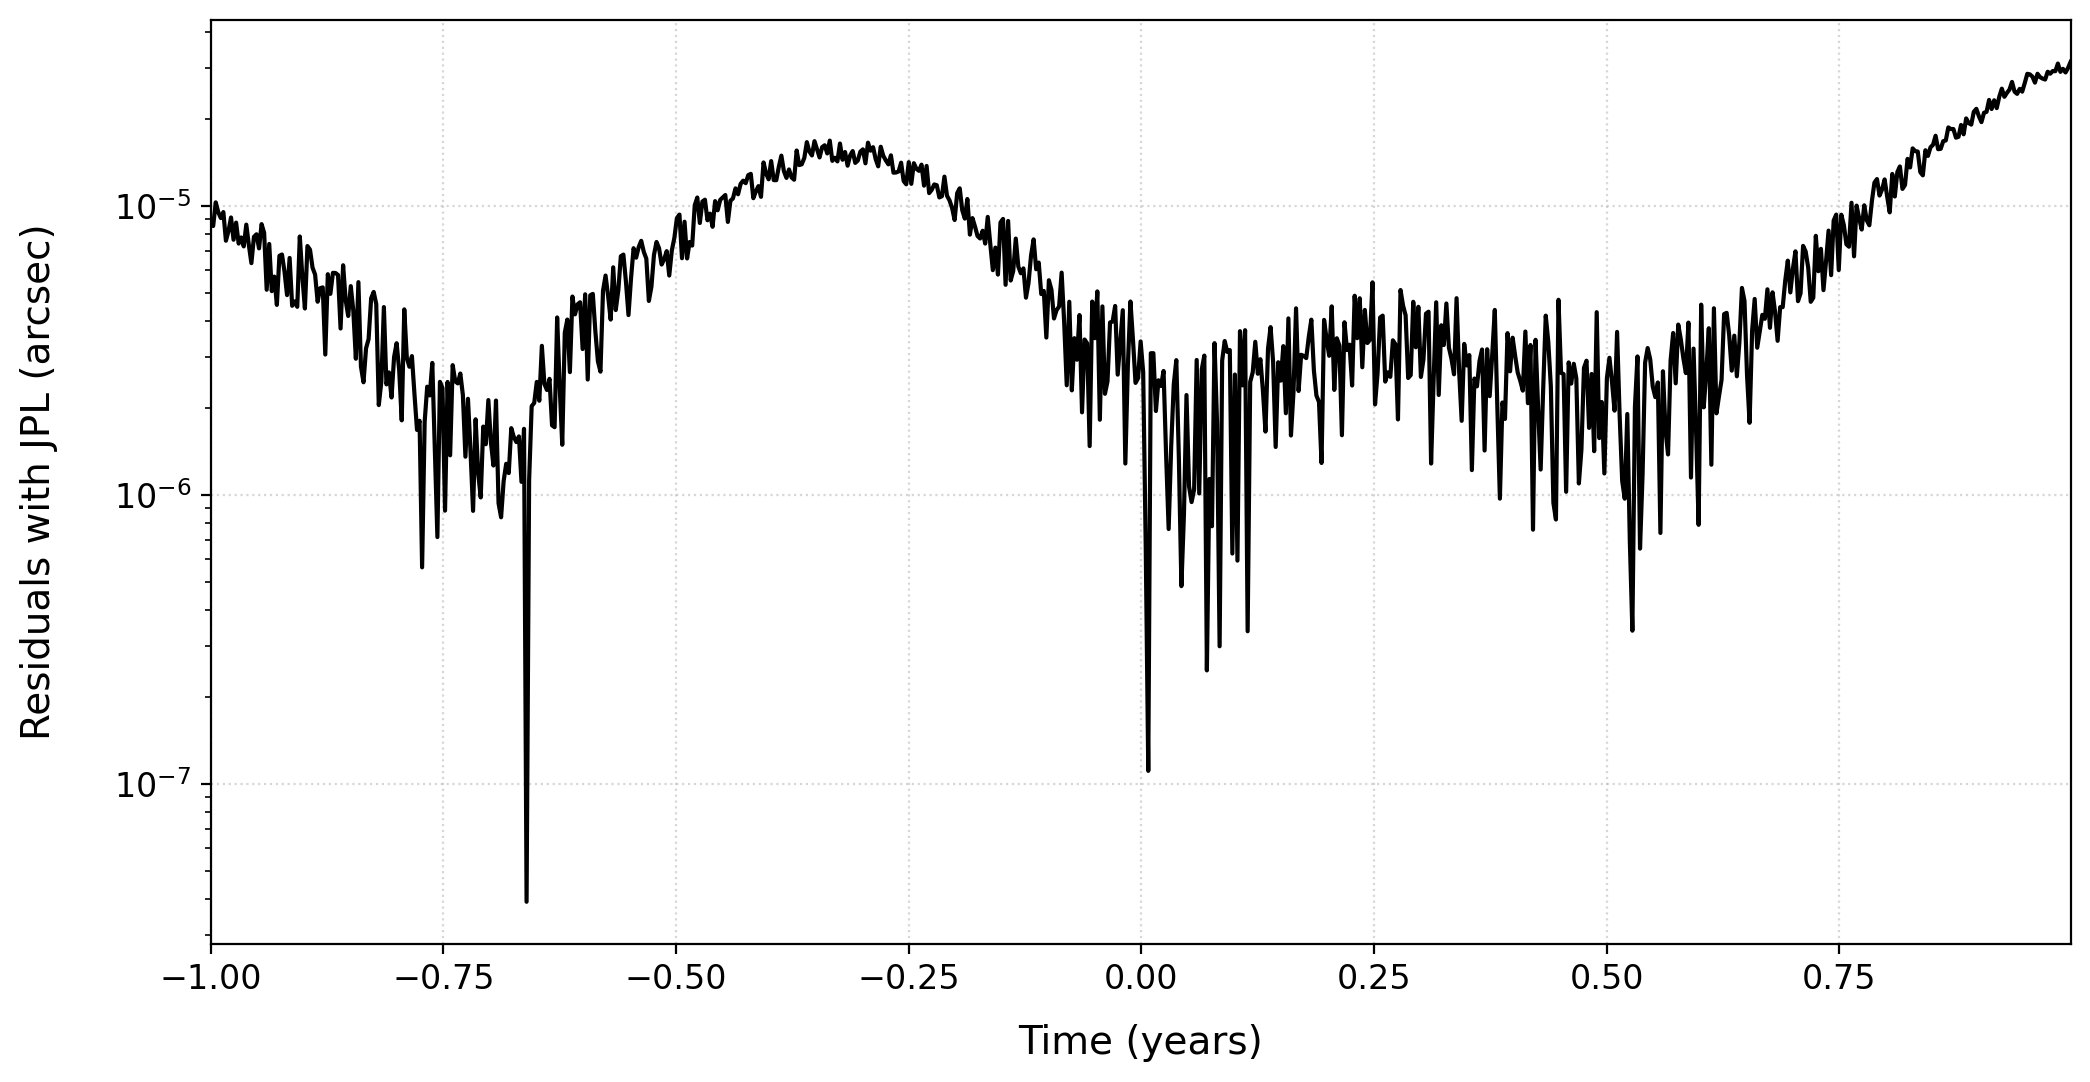

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ra_residuals = (ephem_Horizons['RA'] - ras) * 3600 #* 1e6
dec_residuals = (ephem_Horizons['DEC'] - decs) * 3600 #* 1e6
residuals = np.sqrt(ra_residuals**2 + dec_residuals**2)

t = (epochs - t0) / 365.25
ax.plot(t, residuals, label='Residuals', color='black')


ax.set_xlabel('Time (years)', fontsize=14, labelpad=10)
ax.set_ylabel('Residuals with JPL (arcsec)', fontsize=14, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_ylim(bottom=1e-6)
ax.set_yscale('log')
ax.set_xlim(left=t.min(), right=t.max())
ax.grid(ls=':', alpha=0.5)

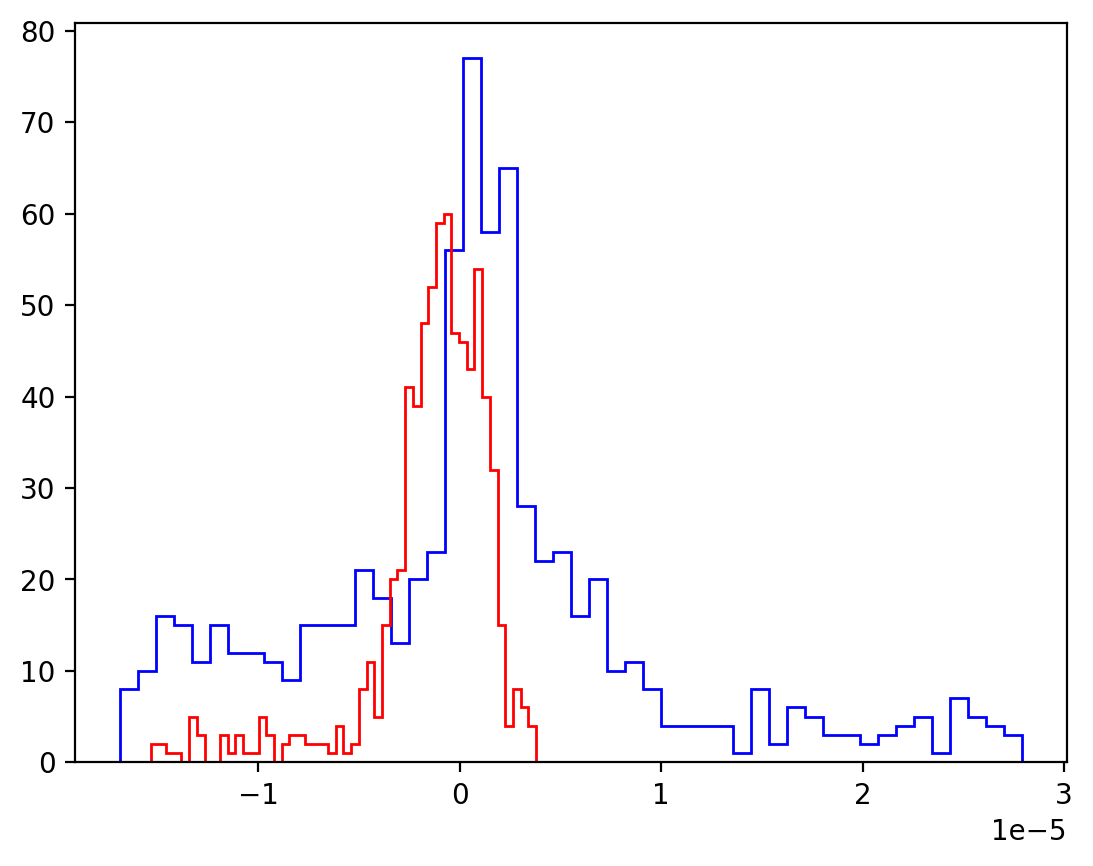

In [15]:
_ = plt.hist(ra_residuals, bins=50, histtype='step', color='blue', label='RA')
_ = plt.hist(dec_residuals, bins=50, histtype='step', color='red', label='Dec')

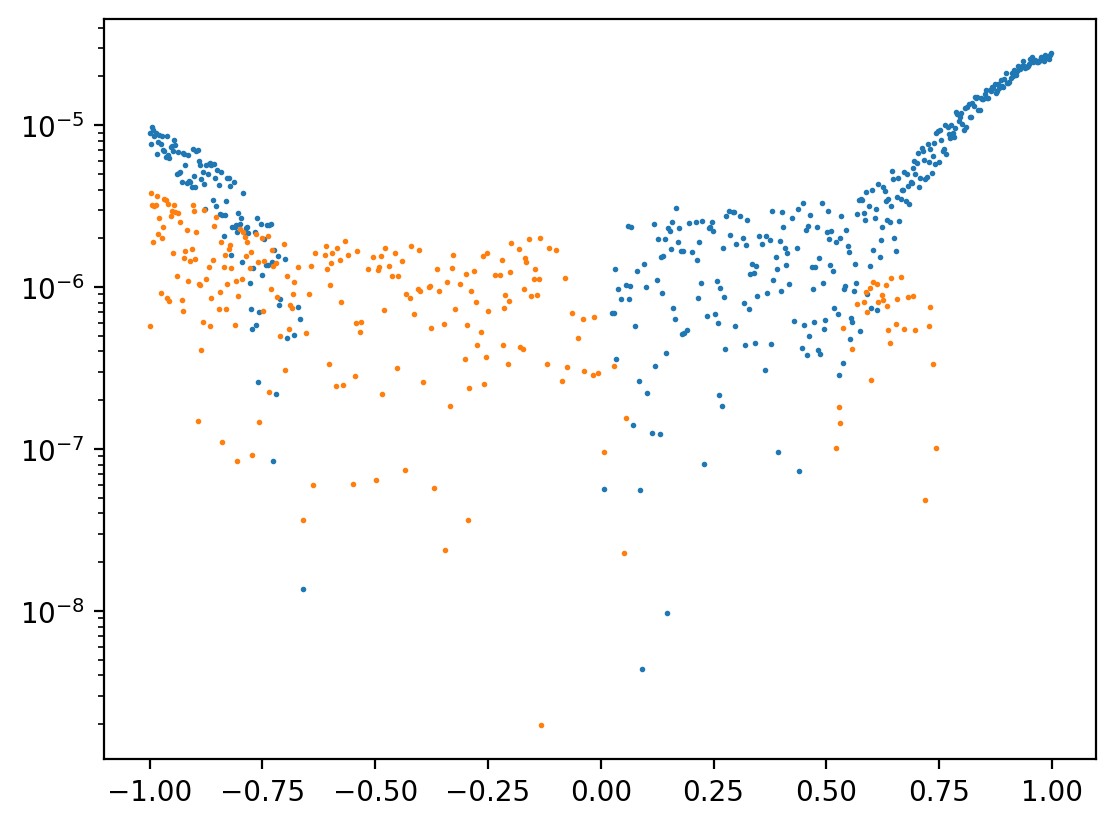

In [16]:
plt.scatter(t, ra_residuals, s=1)
plt.scatter(t, dec_residuals, s=1)
plt.yscale('log')